# Experiments with Triplet Loss for Finding Lower-Dimensional Embedding of GMMs

## Set-Up

### Data
The data comes from a Gaussian mixture over 'k' different components. 

More concretely, there are $k$ hidden components  $v_1, v_2,\dots,  v_{k}$ part of a $d_k$-dimensional subspace of $\mathbb{R^d}.$ For now, we take them to be standard Gaussian in the first $d_k$ coordinates 
 
There is also a distribution with marginals $p[1], p[2], \ldots, p[k]$ over $[k].$ The $n$ observables are generated as follows:

- Each $X_i$ comes from the $i$-th mixture with probability $p[i].$ Let $L_i\in [k]$ be the label of $X_i.$

- The $i$-th mixture has distribution $\mathcal{N}(v_i, \sigma^2(I - v_iv_i^T).$ That is, it equals $v_i$ plus istropic Gaussian nose in the orthogonal space to $v_i$ with each coordinate of variance $\sigma.$ 


### Goal 
The input is $(X_i, L_i)_{i \in [n]}.$

The Goal is to find a projection matrix $P\in \mathbb{R}^{n\times d}$ such that $PX_i = Pv_j$ whenever $X_i$ comes from component $j.$ 

## Approach
The approach is to find $P$ by minimizing the following triplet loss:
$$
\sum_{anc,pos,neg\in [n]\; : \; L_{anc} = L_{pos}\neq L_{neg}} \max(0, \|PX_{anc} - PX_{pos}\|^2_2 - \|PX_{anc} - PX_{neg}\|_2^2 + margin)
$$

We minimize this running gradient descent over the $n\times d$ Stiefel manifold (Riemannina manifold of projection matrices from $\mathbb{R}^n$ to 
$\mathbb{R}^d$). We rely on the pymanopt package: https://pymanopt.org


In [1]:
# Libraries and files
import numpy as np
import pymanopt as pymanopt
from pymanopt.manifolds import Stiefel
from pymanopt.optimizers import ConjugateGradient
from GMMsExample import GMMDataGeneration as GMMD #file that generates data
from GMMsExample import ProjectionEmbedding #file that generates data
from MainFunctions import TripletLossClass #file with tripletloss primitives
from MainFunctions import L2distanceSquared as L2Dist
import matplotlib.pyplot as plt
from MainFunctions import VisualizingFunctions

2024-09-27 15:11:16.805889: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# Parameters
k = 2 #number of components
dk = 2 # dimension of components
d = 10 # dimension of samples
n = 1000 #number of samples
sigma = 1 #sigma, noise size
p = [.5, .5] # mixture weights

In [10]:
# Generating data
(V, X, L) = GMMD.generate_GMM_data(k,n,d,sigma,dk,p)
print(L)

[0 1 0 1 1 1 0 0 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 0 0 0 1 1 0 1
 0 0 0 0 1 0 0 1 1 1 1 1 0 0 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 1 0 0 0 1 1 1
 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 0 1 0 0 1 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 1 0
 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0 0 1 1 0 1 1 0 1 1
 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 1 1 0
 0 0 1 0 1 0 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 1 0 0
 0 1 0 1 0 0 1 0 0 1 0 0 0 1 1 0 0 1 1 0 0 1 1 0 1 1 1 0 0 1 0 1 0 1 0 1 0
 1 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 0
 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 0 0 1 0 0 0 1 1 0 1 0 1
 1 0 1 1 1 1 1 0 0 0 1 1 0 0 0 0 1 1 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 1 0 1
 0 0 1 0 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 1 0 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0 1
 1 1 0 0 1 1 1 1 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 1 0 1 1 0 1 1 1
 1 0 0 1 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 1 1
 0 1 1 0 1 1 1 0 0 0 1 0 

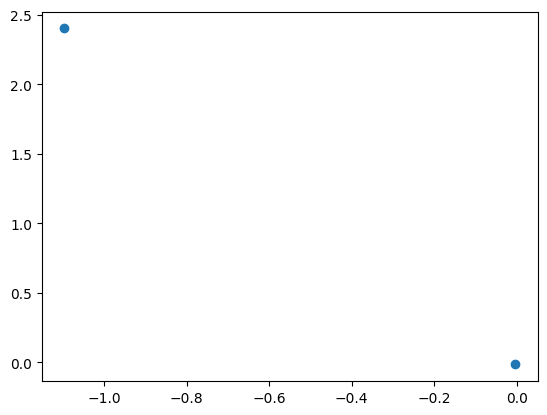

In [11]:
# Components
plt.scatter(x = V[:,0], y = V[:,1])

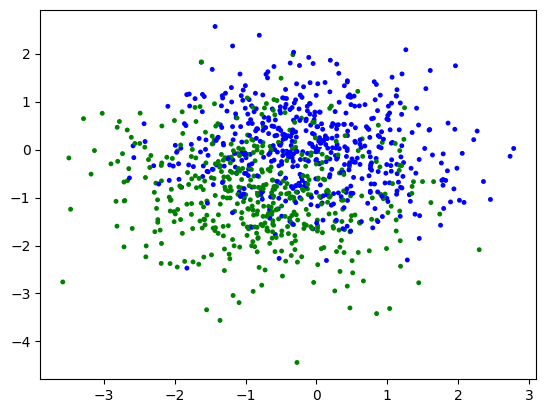

In [12]:
stiefel = pymanopt.manifolds.Stiefel(n = d, p = dk)
RP = stiefel.random_point()

VisualizingFunctions.visualize(X,L,V,RP)

In [13]:
#Embedding Function
def run(X, L,d, dk,margin):
    projector = Stiefel(n = d, p = dk)
    triplet_loss_func = TripletLossClass.tripletloss(X = X, labels = L, metric = L2Dist, margin = margin,
                                              embedding = ProjectionEmbedding,manifold = projector)
    (cost, grad) = triplet_loss_func.create_cost_and_grad()
    problem = pymanopt.Problem(
        projector, cost = cost,
                    euclidean_gradient=grad
    )

    optimizer = ConjugateGradient(verbosity=2 , beta_rule="PolakRibiere")

    result = optimizer.run(problem)
    return (result,triplet_loss_func)

In [14]:
# Visualization Function

In [ ]:
# First example
margin = .3
(result,loss_class) = run(X,L,d,dk,margin)
P = result.point

Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    


0


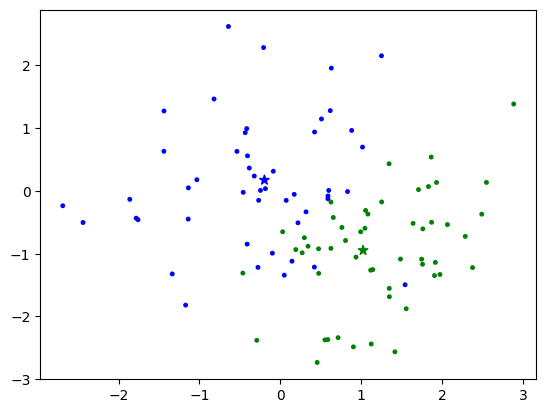

In [8]:
print(loss_class.num_zero_losses)
VisualizingFunctions.visualize(X,L,V,P)

## Role of Margin

In [51]:
margins = np.linspace(0,10,20)
print(margins)

k = 2 #number of components
dk = 2 # dimension of components
d = 10 # dimension of samples
n = 30 #number of samples
sigma = 0.3 #sigma, noise size
p = [.5, .5] # mixture weights

(V, X, L) = GMMD.generate_GMM_data(k,n,d,sigma,dk,p)
P_vals = []

for idx,margin in enumerate(margins):
    P_vals.append(run(X,L,d,dk,margin).point)

    

[ 0.          0.52631579  1.05263158  1.57894737  2.10526316  2.63157895
  3.15789474  3.68421053  4.21052632  4.73684211  5.26315789  5.78947368
  6.31578947  6.84210526  7.36842105  7.89473684  8.42105263  8.94736842
  9.47368421 10.        ]
[[-0.57158927  1.49279359  0.          0.        ]
 [ 1.36865545 -0.75694973  0.          0.        ]]
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         +0.0000000000000000e+00    0.00000000e+00    
Terminated - min grad norm reached after 1 iterations, 0.00 seconds.

Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         +6.0361444644185760e+01    3.89836116e+02    
   2         +2.2465182540978175e+00    3.35965327e+01    
   3         +1.0133084913758044e+00    2.52461298e+01    
   4         +0.0000000000000000e+00    0.00000000e+00    
Terminated - min grad n

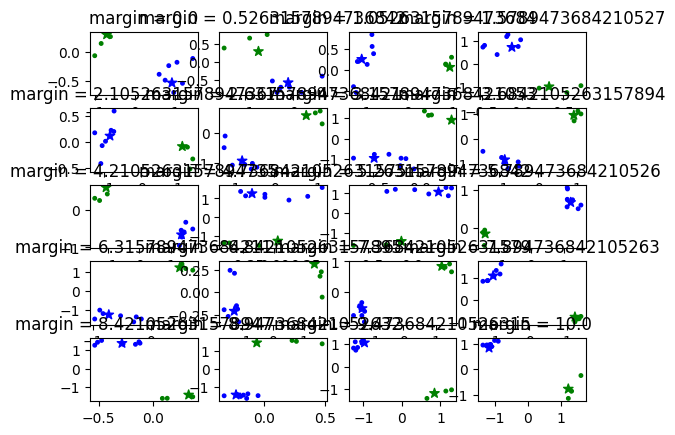

In [52]:
fig, axs = plt.subplots(5, 4)  

unique_labels = np.unique(L)
colors = {}
for idx,label in enumerate(unique_labels):
    colors[label] = basecolors[idx]

for idx in range(len(margins)):
    P = P_vals[idx]
    projected_components = np.matmul(P.T, V.T)
    color_components = [colors[label] for label in unique_labels]
    
    projected_samples = np.matmul(P.T, X.T)
    color_samples = [colors[label] for label in L]
    
    axs[idx//4, idx%4].scatter(x = projected_components[0,:], y = projected_components[1,:], marker = "*", s = 50,color = color_components)
    axs[idx//4, idx%4].scatter(x = projected_samples[0,:], y = projected_samples[1,:], marker = ".", s = 25,color = color_samples)
    axs[idx//4, idx%4].set_title("margin = "+str(margins[idx]))
plt.show()

In [53]:
margins

array([ 0.        ,  0.52631579,  1.05263158,  1.57894737,  2.10526316,
        2.63157895,  3.15789474,  3.68421053,  4.21052632,  4.73684211,
        5.26315789,  5.78947368,  6.31578947,  6.84210526,  7.36842105,
        7.89473684,  8.42105263,  8.94736842,  9.47368421, 10.        ])

In [21]:
-np.ones((3,3))

array([[-1., -1., -1.],
       [-1., -1., -1.],
       [-1., -1., -1.]])